In [1]:
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
base_dir = os.path.join("/home/jovyan/work/Corona/COVID-19")
sys.path.append(base_dir)
import model as md

In [2]:
merger = md.Merger(data_dir="data", load_from_raw=False, load_from_agg=True)
# merger.merge_deaths_df()
df = merger.load_deaths_df()

/opt/conda/lib/python3.7/site-packages/pyarrow/compat.py:25: FutureWarning: pyarrow.compat has been deprecated and will be removed in a future release
  "future release", FutureWarning)


In [3]:
df["Kor_class"] = df["Kor"].apply(lambda cell: cell - (cell % 10), meta=('Kor', 'int64'))
df["week"] = df["date"].dt.week + df["date"].dt.year * 100
df["day"] = df["date"].apply(
    lambda cell: cell - pd.to_timedelta(cell.dayofweek, unit="D"), meta=('date', 'datetime64[ns]')
)
df_group = df.groupby(["day", "Kor_class"]).agg({"Nem":"count"}).reset_index()
pd_df_group = df_group.compute()

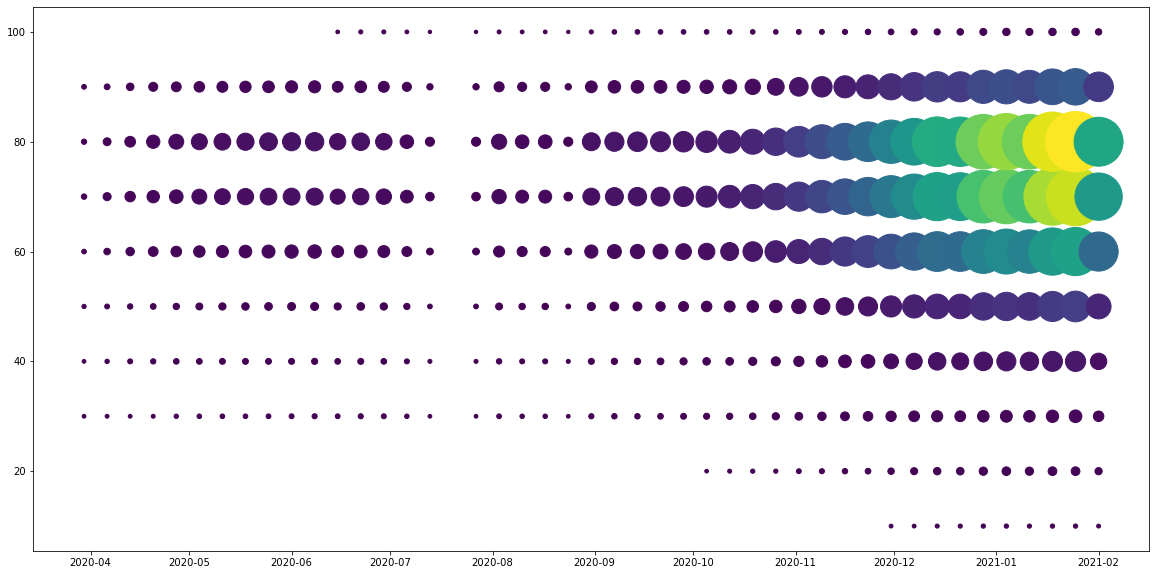

In [4]:
plt.subplots(figsize=(20,10))
plt.scatter(
    x=pd_df_group["day"], y=pd_df_group["Kor_class"], 
    s=10+pd_df_group["Nem"]**0.8, c=pd_df_group["Nem"])
plt.show()